In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import muon_data, pileup_data, muon_data_split, pileup_data_split, \
                    mix_training_inputs

from nn_models import create_model, create_model_bn, create_model_pruned, \
                      create_model_sequential, create_model_sequential_regularized, \
                      lr_decay, modelbestcheck, modelbestcheck_weights

from nn_training import train_model, train_model_sequential

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_1_7
[INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO    ] Using tensorflow 1.5.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.0.0
[INFO    ] Using sklearn 0.19.2


In [2]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.3)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.16.npz ...
[INFO    ] Loaded the variables with shape (3312660, 87)
[INFO    ] Loaded the parameters with shape (3312660, 3)
[INFO    ] Loaded # of training and testing events: (2318862, 993798)


In [3]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=30)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.zeros((pu_x_train.shape[0],), dtype=np.float32) + mask_value, np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.zeros((pu_x_test.shape[0],), dtype=np.float32) + mask_value, np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from ../test7/histos_tbd.16.npz ...
[INFO    ] Loaded the variables with shape (351553, 87)
[INFO    ] Loaded the auxiliary PU info with shape (351553, 4)
[INFO    ] Loaded # of training and testing events: (169628, 181925)


In [4]:
# Create models
# model_seq is a densely connected NN with 3 hidden layers and 1 output node
# model is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

model_seq = create_model_sequential(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg)

#model_seq = create_model_sequential_regularized(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg)

model = create_model(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                     nodes1=48, nodes2=32, nodes3=20)

#model = create_model_bn(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
#                        nodes1=48, nodes2=32, nodes3=20)

### Training

In [5]:
# Hello, what do you want to train today?

training_seq = False
training_func = False
training_pruned = False

In [6]:
# Training (Sequential)

if training_seq:
  assert(keras.backend.backend() == 'tensorflow')

  history = train_model_sequential(model_seq, x_train, y_train[0] if isinstance(y_train, list) else y_train, 
                                   model_name='model', epochs=200, batch_size=256,
                                   callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [7]:
# Training (Functional)

if training_func:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut)
  else:
    raise Exception('add_noise must be set to True')

  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=300, batch_size=256,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [8]:
# Training (with Pruning)
# 1. First training: do the same thing as 'Training (Functional)', but with l1_reg and large batch_size.
# 2. Apply pruning
# 3. Retraining with pruned model, repeat the same thing as 'Training (Functional)'

if training_pruned:
  assert(keras.backend.backend() == 'tensorflow')
  
  # First training
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut)
  else:
    raise Exception('add_noise must be set to True')
  
  l1_reg = 3e-4
  model = create_model(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                       nodes1=48, nodes2=32, nodes3=20)
  
  logger.info('Training model with l1_reg: {0}'.format(l1_reg))
  
  small_epochs = 100
  large_batch_size = 8192
  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=small_epochs, batch_size=large_batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [9]:
if training_pruned:
  # Apply pruning
  from nn_models import clone_model
  model_unpruned = clone_model(model)  # deep copy
  model_unpruned.set_weights(model.get_weights())

  pruning_percentile = 50.
  pruned = prune_model(model, percentile=pruning_percentile)
  (weightsPerLayer, droppedPerLayer, binaryTensorPerLayer, allWeightsByLayer, allWeightsArray) = pruned

In [10]:
if training_pruned:
  # Check pruning
  percentiles = [5.,pruning_percentile,95.]
  colors = ['r','g','r']
  vlines = np.percentile(allWeightsArray,percentiles,axis=-1)

  #xmin = np.min(allWeightsArray[np.nonzero(allWeightsArray)])
  #xmax = np.max(allWeightsArray)
  xmin = 1e-7
  xmax = 1
  bins = np.linspace(xmin, xmax, 50)
  logbins = np.geomspace(xmin, xmax, 50)

  #plt.figure()
  #plt.hist(allWeightsByLayer.values(),bins=bins,histtype='bar',stacked=True,label=allWeightsByLayer.keys())
  #plt.legend(prop={'size':10}, loc='upper right')
  #axis = plt.gca()
  #ymin, ymax = axis.get_ylim()
  #for vline, percentile, color in zip(vlines, percentiles, colors):
  #  if percentile==0: continue
  #  if vline < xmin: continue
  #  plt.axvline(vline, 0, 1, color=color, linestyle='dashed', linewidth=1, label='%s%%'%percentile)
  #  plt.text(vline, ymax+0.01*(ymax-ymin), '%s%%'%percentile, color=color, horizontalalignment='center')
  #plt.ylabel('Number of Weights')
  #plt.xlabel('Absolute Relative Weights')
  #plt.show()

  plt.figure()
  plt.hist(allWeightsByLayer.values(),bins=logbins,histtype='bar',stacked=True,label=allWeightsByLayer.keys())
  plt.legend(prop={'size':10}, loc='upper left')
  plt.semilogx()
  axis = plt.gca()
  ymin, ymax = axis.get_ylim()
  for vline, percentile, color in zip(vlines, percentiles, colors):
    if percentile==0: continue
    if vline < xmin: continue
    plt.axvline(vline, 0, 1, color=color, linestyle='dashed', linewidth=1, label='%s%%'%percentile)
    plt.text(vline, ymax+0.01*(ymax-ymin), '%s%%'%percentile, color=color, horizontalalignment='center')
  plt.ylabel('Number of Weights')
  plt.xlabel('Absolute Relative Weights')
  plt.show()

In [11]:
if training_pruned:
  # Retraining with pruned_model
  from nn_models import ZeroSomeWeights as zero_some_weights
  constraints = []
  for layer in model_unpruned.layers:
    if layer.name.startswith('dense_'):
      binary_tensor = binaryTensorPerLayer[layer.name]
      logger.info('Found binary tensor {0} with shape {1}'.format(layer.name, binary_tensor.shape))
      constraint = zero_some_weights(binary_tensor)
      constraints.append(constraint)
  constraint1, constraint2, constraint3 = constraints  # len() must be equal to 3
  
  l1_reg = 0.0
  model = create_model_pruned(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                              nodes1=48, nodes2=32, nodes3=20, constraint1=constraint1, constraint2=constraint2, constraint3=constraint3)
  
  logger.info('Retraining model with constraints.')
  
  normal_epochs = 200
  normal_batch_size = 256
  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=normal_epochs, batch_size=normal_batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [12]:
# Validation
#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=2048)

if training_seq or training_func or training_pruned:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [13]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')
eps = 1e-4
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

# Setup Gaussian fit
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
  return a*np.exp(-0.5*np.square((x-x0)/sigma))

def fit_gaus(hist, edges, mu=0., sig=1.):
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist),mu,sig])
  return popt

In [14]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
loaded_model = load_my_model(name='model', weights_name='model_weights')

nentries_test = x_test.shape[0]//4

# Prepare x_test_ndof
x_test_ndof = (x_mask_test[:nentries_test] == False).sum(axis=1)
#print x_test_ndof.shape, x_test_ndof

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] Loaded model from model.json and weights from model_weights.h5


[INFO    ] # of entries: 248449, mean: 0.0011569596827, std: 0.0330159068108
[INFO    ] gaus fit (a, mu, sig): [5.15386131e+04 5.90463834e-04 2.92528193e-02]


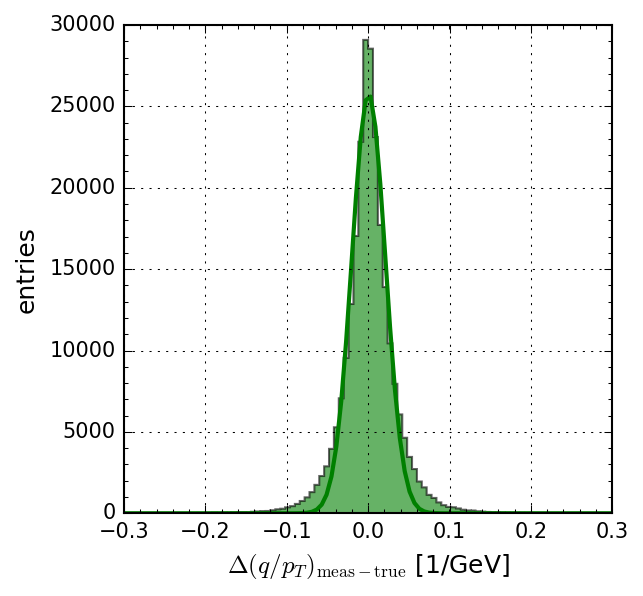

In [15]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

[INFO    ] # of entries: 248449, mean: 1.19561696053, std: 0.209907829762
[INFO    ] gaus fit (a, mu, sig): [ 6.18473470e+04 -9.70871257e-03 -1.64248344e-01]


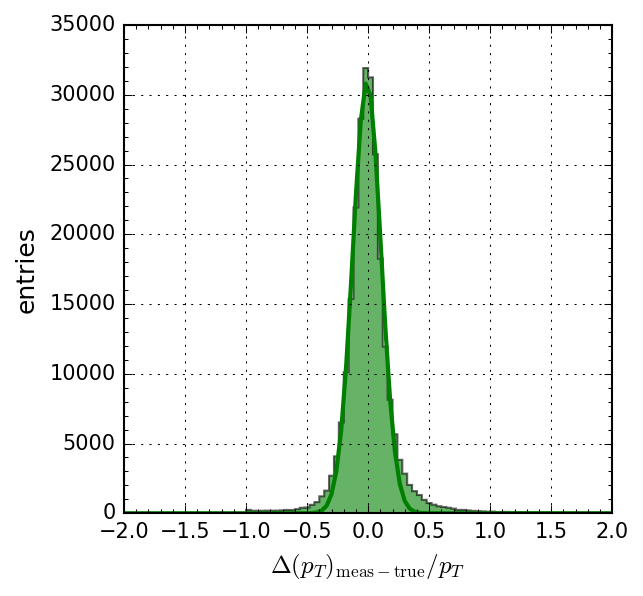

In [16]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


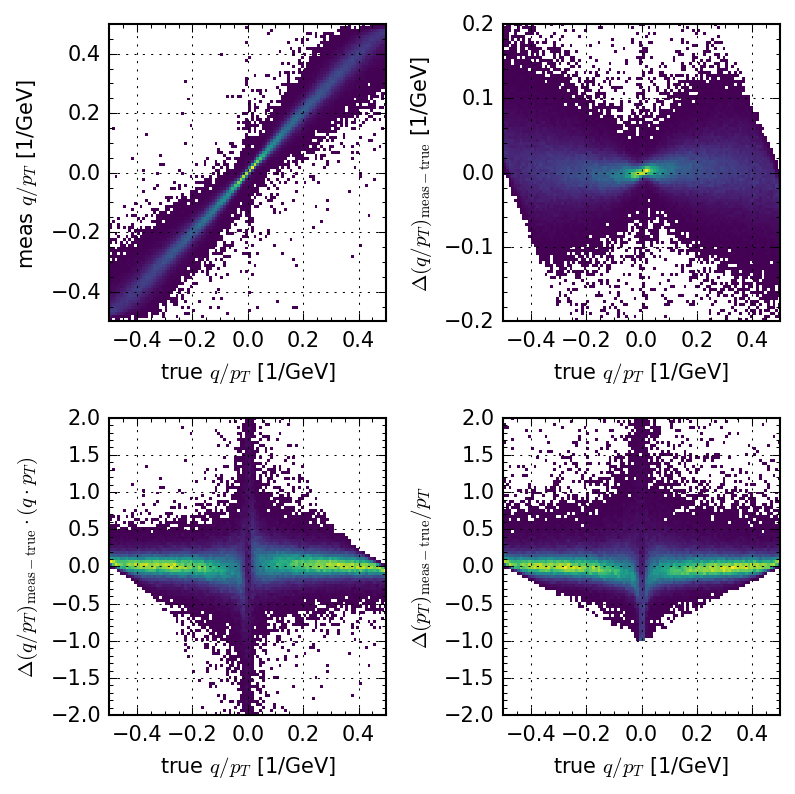

In [17]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [18]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[np.abs(yy_i) < 2]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [ 4.77881176e+02 -6.43704700e-02  2.46521495e-01]


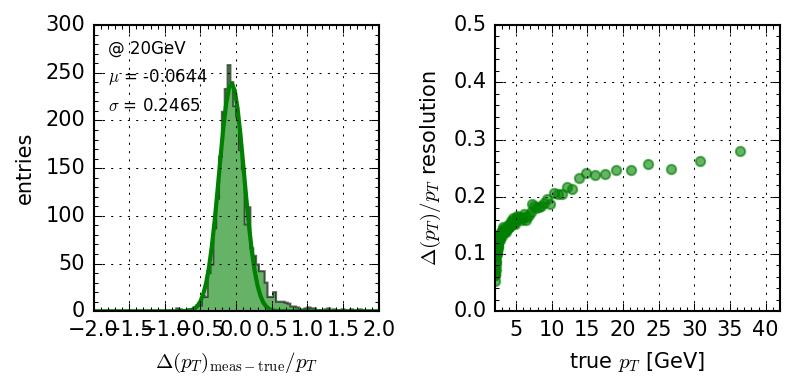

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=np.mean(yy_20GeV), sig=np.std(yy_20GeV[np.abs(yy_20GeV)<1.5]))
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(2,42)
axs[1].set_ylim(0,0.5)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)

plt.show()

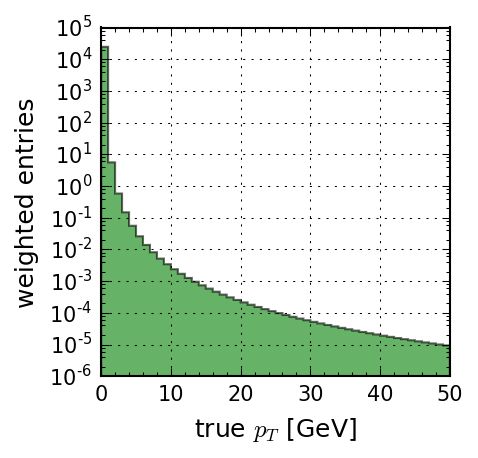

In [20]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [21]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 15.457233429 rate 132.560211182
[INFO    ] 22 GeV threshold 16.6004810333 rate 109.608253479


In [22]:
# Use the predicted rate as loss function/scoring in training
if True:
  from nn_models import NewKerasRegressor
  estimator = NewKerasRegressor(build_fn=create_model_sequential, reg_pt_scale=reg_pt_scale, min_pt=20., max_pt=22., coverage=90.,
                                nvariables=nvariables, lr=learning_rate)

  estimator.model = loaded_model

  # Cross check
  print estimator.score2(x_test[:nentries_test], y_test[0][:nentries_test] if isinstance(y_test, list) else y_test)

-132.56021


### Classification Results

In [23]:
# Prepare pu_x_test_ndof
pu_x_test_ndof = (pu_x_mask_test == False).sum(axis=1)
#print pu_x_test_ndof.shape, pu_x_test_ndof

# Prepare y_test_true, y_test_meas
y_test_true = [y_test[0][:nentries_test, np.newaxis].copy(), y_test[1][:nentries_test, np.newaxis].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true = [y_test_true[0], y_test_true[1]]
y_test_meas = [y_test_meas[0], y_test_meas[1]]
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=2048)
pu_y_test_meas = [pu_y_test_meas[0].reshape(-1), pu_y_test_meas[1].reshape(-1)]
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

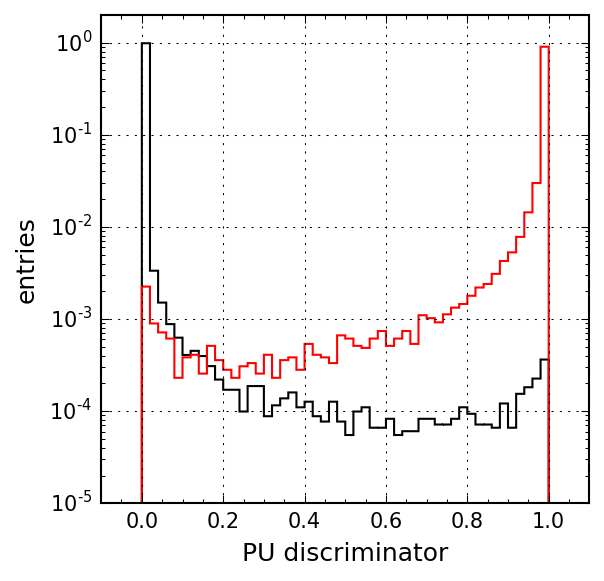

In [24]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black')
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red')
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

[INFO    ] auc: 0.998507858257
[INFO    ] thr: [0.9910, 0.9847, 0.9773, 0.9583, 0.9353, 0.9041, 0.8190, 0.6450, 0.1385]
[INFO    ] tpr: [0.9001, 0.9317, 0.9501, 0.9701, 0.9801, 0.9851, 0.9908, 0.9952, 0.9990]
[INFO    ] fpr: [0.0037, 0.0048, 0.0065, 0.0089, 0.0116, 0.0130, 0.0147, 0.0189, 0.0358]


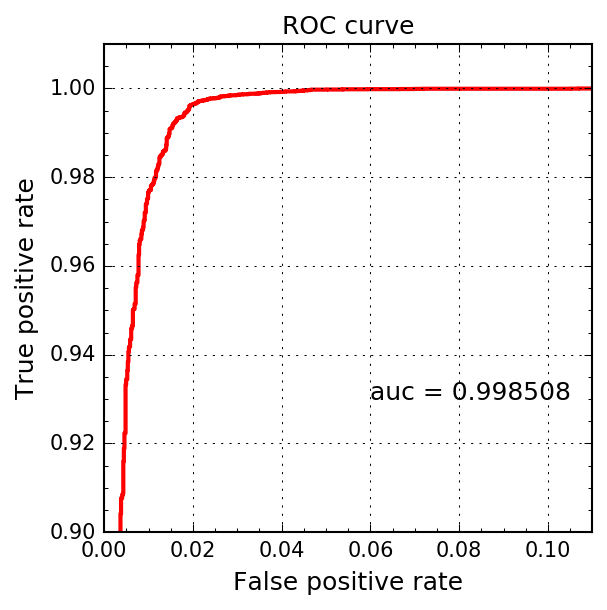

In [25]:
# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))

zz_tmp = np.abs(1.0/zz) > discr_pt_cut
xx = xx[zz_tmp]
yy = yy[zz_tmp]

fpr, tpr, thresh = roc_curve(xx, yy)  # (y_true, y_meas)
auc = roc_auc_score(xx, yy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.98, 0.985, 0.99, 0.995, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.11)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

In [54]:
# Build a trigger object

pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - abs(ipt - best_ipt)

class MyTrigger(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.7822,  1.5017,  1.5567,  1.8140,  2.1903,  2.6407,  3.1506,  3.7038,
                  4.2855,  4.8892,  5.5135,  6.1538,  6.8062,  7.4675,  8.1358,  8.8129,
                  9.5006, 10.1893, 10.8752, 11.5731, 12.2918, 13.0238, 13.7528, 14.4833,
                 15.2289, 15.9930, 16.7752, 17.5625, 18.3535, 19.1416, 19.9296, 20.7557,
                 21.6340, 22.5020, 23.2818, 23.9860, 24.6808, 25.4054, 26.2238, 27.0751,
                 27.9190, 28.8167, 29.8185, 30.8708, 31.7760, 32.5681, 33.4202, 34.3624,
                 35.3410, 36.2845, 37.2035, 38.1359, 38.9998, 39.7940, 40.5750, 41.4005,
                 42.2826, 43.2236, 44.3138, 45.5656, 46.9730, 48.6543, 50.0740, 51.0015,
                 51.8566, 52.6991, 53.5378, 54.3748, 55.2111, 56.0469, 56.8824, 57.7177,
                 58.5530, 59.3881, 60.2232, 61.0583, 61.8933, 62.7283, 63.5633, 64.3982,
                 65.2332, 66.0681, 66.9030, 67.7380, 68.5729, 69.4078, 70.2427, 71.0777,
                 71.9126, 72.7475, 73.5824, 74.4173, 75.2522, 76.0871, 76.9220, 77.7569,
                 78.5918, 79.4267, 80.2616, 81.0965, 81.9314, 82.7663, 83.6012, 84.4361,
                 85.2710, 86.1059, 86.9408, 87.7757, 88.6106, 89.4455, 90.2804, 91.1153,
                 91.9502, 92.7851, 93.6200, 94.4549, 95.2898, 96.1247, 96.9595, 97.7944]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]

  def get_trigger_pt(self, x, y_meas):
    #zone = int(x[(nlayers*6) + 1] * 5)

    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-8)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return int(binx)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if (binx+1) >= self.s_nbins:  # check boundary
      binx = self.s_nbins-2

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, x, ndof, y_meas, y_discr, discr_pt_cut=14.):
    trk_mode = 0
    x_mode_vars = np.equal(x[nlayers*6+3:nlayers*6+8], 1)
    for i, x_mode_var in enumerate(x_mode_vars):
      if i == 0:
        station = 1
      else:
        station = i
      if x_mode_var:
        trk_mode |= (1 << (4 - station))

    straightness = int(x[(nlayers*6) + 0] * 6) + 6

    ipt1 = straightness
    ipt2 = find_pt_bin(y_meas)
    quality1 = emtf_road_quality(ipt1)
    quality2 = emtf_road_quality(ipt2)

    if trk_mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > discr_pt_cut:
        if ndof <= 3:
          #trigger = (y_discr > 0.8)
          trigger = (y_discr > 0.9900)  # 90% coverage
          #trigger = (y_discr > 0.9999)  # 95% coverage
        else:
          #trigger = (y_discr > 0.5393)
          trigger = (y_discr > 0.9041) # 98.5% coverage
          #trigger = (y_discr > 0.9929) # 99% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger

mytrigger = MyTrigger()

In [55]:
# Efficiency
eff_data = []

for x, ndof, y_meas, y_discr, y_true in zip(x_test, x_test_ndof, y_test_meas[0], y_test_meas[1], y_test_true[0]):
  zone = int(x[(nlayers*6) + 1] * 5)
  
  passed = mytrigger.pass_trigger(x, ndof, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed))

eff_data = np.asarray(eff_data)
print eff_data.shape, eff_data

(248449, 5) [[3.         4.06132793 4.75334072 5.20552158 1.        ]
 [3.         2.57501101 2.51080799 2.65172219 1.        ]
 [1.         2.55024886 2.51108789 2.65200758 1.        ]
 ...
 [3.         6.10882711 5.28759289 5.88179159 1.        ]
 [2.         4.21373606 4.27398729 4.6163125  1.        ]
 [0.         6.54953098 6.20631981 7.07907867 1.        ]]


10.0 [           nan            nan            nan            nan
 1.66871463e-04 8.51101953e-04 3.31041508e-03 1.31550218e-02
 4.82456140e-02 1.89551037e-01 5.71664394e-01 9.04029692e-01
 9.64767965e-01 9.68121827e-01 9.71443542e-01 9.72313777e-01
 9.69100039e-01 9.73196881e-01 9.75936884e-01 9.81951220e-01
 9.76954361e-01 9.77786919e-01 9.79276896e-01 9.76733781e-01
 9.71241830e-01 9.74628171e-01]
20.0 [           nan            nan            nan            nan
 1.51701330e-05 1.11987099e-04 1.81890938e-04 1.36462882e-03
 2.34422263e-03 4.52989732e-03 1.28471973e-02 4.88865323e-02
 1.61881111e-01 4.13197970e-01 6.60728321e-01 8.11470007e-01
 8.95712630e-01 9.36159844e-01 9.55818540e-01 9.69756098e-01
 9.69724356e-01 9.73673385e-01 9.75308642e-01 9.73601790e-01
 9.67755991e-01 9.69816273e-01]
30.0 [           nan            nan            nan            nan
 0.00000000e+00 6.71922595e-05 1.09134563e-04 6.00436681e-04
 1.13430127e-03 2.01328770e-03 3.73214670e-03 8.27147402e-03
 1.862

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


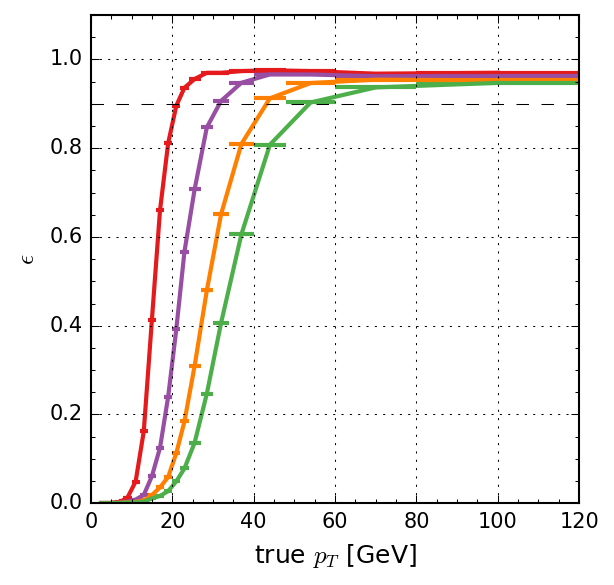

In [56]:
# Efficiency
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

denom_hist, edges = np.histogram(eff_data[:, 1], bins=eff_pt_bins)

plt.figure()
pt_list = (10., 20., 30., 40., 50., 60.)

for pt, color in zip(pt_list, my_palette):
  passed = (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)
  eff_hist = np.true_divide(num_hist, denom_hist)
  print pt, eff_hist

  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = 0  #FIXME: get error bars
  ydata = eff_hist
  if pt == 10.:
    pass
  else:
    plt.errorbar(xdata, ydata, xerr=xerr, color=color, marker=',', capsize=0)

plt.plot(eff_pt_bins, np.ones_like(eff_pt_bins)*0.9, ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [57]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((4,nbinsx), dtype=np.float32)

for j in xrange(4):  # j = zone0-1, zone2-3, zone4-5, all zones
  if j == 3:
    eff_data_tmp = (eff_data[:,0] >= 0)
  else:
    eff_data_tmp = (eff_data[:,0] == 2*j) | (eff_data[:,0] == 2*j+1)
  xx = eff_data[:,1][eff_data_tmp]
  yy = eff_data[:,2][eff_data_tmp]
  zz = eff_data[:,4][eff_data_tmp]
  
  inds = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= inds) & (inds <= i+step)]
    yy_i = yy[(i <= inds) & (inds <= i+step)]
    zz_i = zz[(i <= inds) & (inds <= i+step)]
    coverage = 90  
    coverage += 2.3 # inefficiency due to fiducial cuts
    #coverage += 100. * (zz_i==0).sum() / (zz_i>=0).sum()  # inefficiency due to PU discr
    pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    # Debug
    if j == 3 and xedges[i] > discr_pt_cut:
      print i, xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    
    xxx[j,i] = pct

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

29 14.5 2.31729055258
30 15.0 2.37326751471
31 15.5 2.33644859813
32 16.0 2.33210969553
33 16.5 2.35667346476
34 17.0 2.40326844509
35 17.5 2.434648898
36 18.0 2.45923549853
37 18.5 2.38898257448
38 19.0 2.60767653091
39 19.5 2.57274119449
40 20.0 2.64247055078
41 20.5 2.54435888852
42 21.0 2.57404795487
43 21.5 2.54462590201
44 22.0 2.36
45 22.5 2.3680930619
46 23.0 2.60303687636
47 23.5 2.66785237884
48 24.0 2.40295748614
49 24.5 1.96525206494
50 25.0 1.8414018414
51 25.5 1.70436938333
52 26.0 1.70692431562
53 26.5 1.7880794702
54 27.0 1.91452991453
55 27.5 1.89015691869
56 28.0 1.91669738297
57 28.5 1.90476190476
58 29.0 1.90661478599
59 29.5 1.86212361331
60 30.0 1.8337408313
61 30.5 1.71979865772
62 31.0 1.71453064724
63 31.5 1.77304964539
64 32.0 1.66358595194
65 32.5 1.56958493198
66 33.0 1.58330334653
67 33.5 1.77777777778
68 34.0 1.92975685064
69 34.5 1.95219123506
70 35.0 1.90082644628
71 35.5 1.66240409207
72 36.0 1.53711023276
73 36.5 1.66666666667
74 37.0 1.61527165932
75 

[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

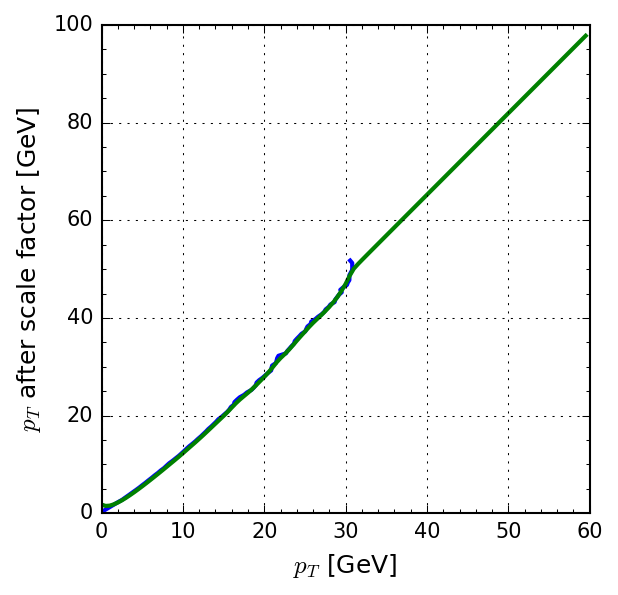

In [58]:
if True:
  plt.figure()
  xdata = (xedges[1:] + xedges[:-1])/2
  #plt.plot(xxx[0,:-16], xdata[:-16])
  #plt.plot(xxx[1,:-16], xdata[:-16])
  #plt.plot(xxx[2,:-16], xdata[:-16])
  plt.plot(xxx[3,:-16], xdata[:-16])
  plt.xlabel(r'$p_{T}$ [GeV]')
  plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

  from scipy.interpolate import Rbf
  rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

  xdata = xedges[:-1]
  ydata0 = rbf0(xdata)
  ydata1 = rbf1(xdata)
  ydata2 = rbf2(xdata)
  ydata3 = rbf3(xdata)
  
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  
  print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
  print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
  
  #plt.legend((line0, line1, line2, line3), ('zone0-1', 'zone2-3', 'zone4-5', 'all zones'), loc='upper left')
  plt.show()

In [59]:
# Rates
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for x, ndof, y_meas, y_discr, aux in zip(pu_x_test, pu_x_test_ndof, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test):
  zone = int(x[(nlayers*6) + 1] * 5)
  
  passed = mytrigger.pass_trigger(x, ndof, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid)
  ievt = int(ievt)
  
  if jobid < (rates_njobs-1):
    if passed:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_job = 31
  if jobid == test_job and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(*aux), ndof, pt, y_discr

  31 2826 19.5646 30.0000 6 30.672360305353127 0.9994578
  31 2937 11.6057 19.5000 6 40.89857379153666 0.9994585
  31 3675  3.0667  8.5000 5 6664.014089913088 0.9916481
  31 4581  1.5532 24.0000 4 25.20987992156874 0.9498754


[INFO    ] nevents: 258400/498400


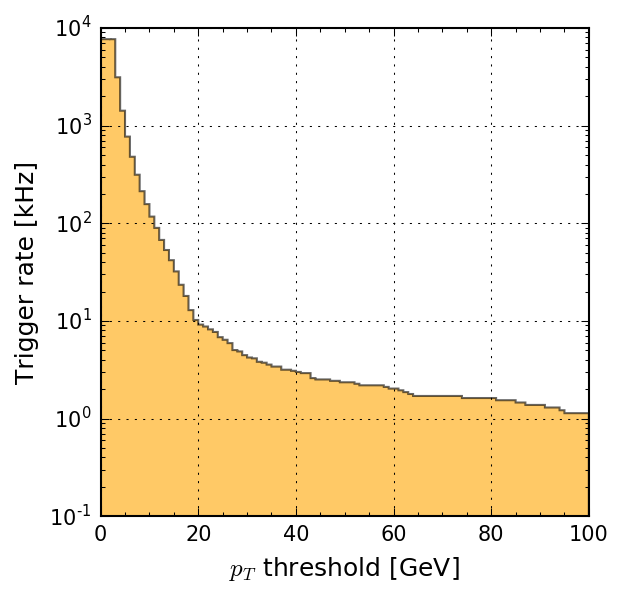

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 12.9121593758, 10.2322773263, 9.17656617612, 8.77052342147, 8.20206355304


[7.68712017e+03 7.68712017e+03 7.68338457e+03 3.12855938e+03
 1.42301738e+03 7.72536916e+02 4.80267354e+02 3.14358296e+02
 2.13253652e+02 1.57219750e+02 1.17102727e+02 8.97354459e+01
 6.75655126e+01 5.32728080e+01 4.19036111e+01 3.21585855e+01
 2.34692706e+01 1.80282978e+01 1.29121594e+01 1.02322773e+01
 9.17656618e+00 8.77052342e+00 8.20206355e+00 7.71481227e+00
 6.82151823e+00 6.41547548e+00 5.92822420e+00 5.03493010e+00
 4.87251300e+00 4.46647025e+00 4.22284461e+00 4.14163606e+00
 3.81680186e+00 3.73559331e+00 3.57317621e+00 3.41075911e+00
 3.41075911e+00 3.16713347e+00 3.16713347e+00 3.08592492e+00
 3.00471637e+00 2.92350782e+00 2.92350782e+00 2.59867363e+00
 2.51746508e+00 2.51746508e+00 2.51746508e+00 2.43625653e+00
 2.43625653e+00 2.35504798e+00 2.35504798e+00 2.35504798e+00
 2.27383943e+00 2.19263088e+00 2.19263088e+00 2.19263088e+00
 2.19263088e+00 2.19263088e+00 2.11142233e+00 2.03021378e+00
 2.03021378e+00 1.94900523e+00 1.86779668e+00 1.78658813e+00
 1.70537958e+00 1.705379

In [60]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11245.6
  nCollBunches = 1866
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
weights = np.zeros_like(rates) + conversion_to_kHz(rates_nevents_1)

#FIXME: get error bars
plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', alpha=0.6)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print hist

In [33]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [34]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    
    nentries_test = 100000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1) or lay in (11,):  # ME1/1, ME1/2, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (2,) or lay in (5,6) or lay in (9,10):  # ME2, RE1, RE2, GE1/1, GE2/1
          coef = 1.0/np.std(x_i)
        else:  # ME3, ME4, RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
    
      ## x_time
      #elif (nlayers*3) <= i < (nlayers*4):
      #  coef = 1.0/np.std(x_i)
      #  print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef  

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [35]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()